In [22]:
import pickle
from collections import namedtuple
import pandas as pd
import numpy as np
from importlib import reload
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl

# bench_util module is in the parent directory, because it will be part of
# the production code.  Add the parent directory to the Path so Python can
# import from there
sys.path.insert(0, '../')   
import bench_util

## Unpickle the Dataframe for Preprocessed Utility Data & Make Utility Function Object

In [23]:
# Unpickle the pre-processed DataFrame
df = pickle.load(open('dfu3.pkl', 'rb'))

# Unpickle the raw utility bill DataFrame, which is needed below to make
# the utility function object.
df_raw = pickle.load(open('df_raw.pkl', 'rb'))

df.head()  # the processed data

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
0,03,Electricity,2010,7,Electricity charge,-,24.137931,35.0,0.000000,2011,1,NaN
1,03,Electricity,2010,7,Electricity charge,kWh,1304.274655,9.5,6656.551724,2011,1,22.712154
2,03,Electricity,2010,8,Electricity charge,-,39.498433,62.0,0.000000,2011,2,NaN
3,03,Electricity,2010,8,Electricity charge,kWh,4940.646254,31.0,26822.236155,2011,2,91.517470
4,03,Electricity,2010,9,Electricity charge,-,16.363636,27.0,0.000000,2011,3,NaN


In [24]:
# this is only needed to update any code changes I may have made
# since last importing the module above.
reload(bench_util)     

# Make an object that has the various utility functions.
# The object needs access to the raw utility bill DataFrame and the spreadsheet
# containing other application data.
ut = bench_util.Util(df_raw, '../data/Other_Building_Data.xlsx')

In [25]:
# Testing site.  Final code will loop through all sites
site = 'ANSBG1'

# DataFrame for Energy Use Overview Report Page


In [26]:
# From the main DataFrame, get only the rows for this site, and only get
# the needed columns for this analysis
usage_df1 = df.query('site_id == @site')[['service_type', 'fiscal_year', 'fiscal_mo', 'mmbtu']]
usage_df1.head()

,service_type,fiscal_year,fiscal_mo,mmbtu
17200,Electricity,2011,1,24.87348
17201,Electricity,2011,1,NaN
17202,Electricity,2011,1,NaN
17203,Electricity,2011,2,50.05404
17204,Electricity,2011,2,NaN


In [27]:
usage_df2 = pd.pivot_table(
    usage_df1, 
    values='mmbtu', 
    index=['fiscal_year'], 
    columns=['service_type'],
    aggfunc=np.sum
)
usage_df2

service_type,Electricity,Natural Gas
fiscal_year,,
2011,640.339345,4910.188200
2012,683.037908,4183.582316
2013,600.549539,3545.521645
2014,616.351563,2163.879000
2015,664.534768,2082.877839
2016,542.173934,2151.683625
2017,362.562222,1343.907375


In [28]:
# Add in columns for the missing services
missing_services = bench_util.missing_services(usage_df2.columns)
bench_util.add_columns(usage_df2, missing_services)
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Sewer,Refuse,Steam,Water
fiscal_year,,,,,,,
2011,640.339345,4910.188200,0.0,0.0,0.0,0.0,0.0
2012,683.037908,4183.582316,0.0,0.0,0.0,0.0,0.0
2013,600.549539,3545.521645,0.0,0.0,0.0,0.0,0.0
2014,616.351563,2163.879000,0.0,0.0,0.0,0.0,0.0
2015,664.534768,2082.877839,0.0,0.0,0.0,0.0,0.0
2016,542.173934,2151.683625,0.0,0.0,0.0,0.0,0.0
2017,362.562222,1343.907375,0.0,0.0,0.0,0.0,0.0


In [29]:
usage_df2 = usage_df2.drop(['Sewer', 'Water', 'Refuse'], axis=1)
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam
fiscal_year,,,,
2011,640.339345,4910.188200,0.0,0.0
2012,683.037908,4183.582316,0.0,0.0
2013,600.549539,3545.521645,0.0,0.0
2014,616.351563,2163.879000,0.0,0.0
2015,664.534768,2082.877839,0.0,0.0
2016,542.173934,2151.683625,0.0,0.0
2017,362.562222,1343.907375,0.0,0.0


In [30]:
# Add a Total column that sums the other columns
usage_df2['Total_Use'] = usage_df2.sum(axis=1)
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use
fiscal_year,,,,,
2011,640.339345,4910.188200,0.0,0.0,5550.527545
2012,683.037908,4183.582316,0.0,0.0,4866.620224
2013,600.549539,3545.521645,0.0,0.0,4146.071185
2014,616.351563,2163.879000,0.0,0.0,2780.230563
2015,664.534768,2082.877839,0.0,0.0,2747.412607
2016,542.173934,2151.683625,0.0,0.0,2693.857559
2017,362.562222,1343.907375,0.0,0.0,1706.469597


In [31]:
# Create a list of columns to loop through and calculate percent total energy
usage_cols = list(usage_df2.columns.values)
usage_cols.remove('Total_Use')

for col in usage_cols:
    col_name = col + "_pct_total_energy"
    usage_df2[col_name] = usage_df2[col] / usage_df2.Total_Use

usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy
fiscal_year,,,,,,,,,
2011,640.339345,4910.188200,0.0,0.0,5550.527545,0.115365,0.884635,0.0,0.0
2012,683.037908,4183.582316,0.0,0.0,4866.620224,0.140352,0.859648,0.0,0.0
2013,600.549539,3545.521645,0.0,0.0,4146.071185,0.144848,0.855152,0.0,0.0
2014,616.351563,2163.879000,0.0,0.0,2780.230563,0.221691,0.778309,0.0,0.0
2015,664.534768,2082.877839,0.0,0.0,2747.412607,0.241877,0.758123,0.0,0.0
2016,542.173934,2151.683625,0.0,0.0,2693.857559,0.201263,0.798737,0.0,0.0
2017,362.562222,1343.907375,0.0,0.0,1706.469597,0.212463,0.787537,0.0,0.0


In [32]:
# Add in degree days
months_present = bench_util.months_present(usage_df1)
deg_days = ut.degree_days_yearly(months_present, site)
usage_df2['hdd'] = deg_days
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd
fiscal_year,,,,,,,,,,
2011,640.339345,4910.188200,0.0,0.0,5550.527545,0.115365,0.884635,0.0,0.0,13802
2012,683.037908,4183.582316,0.0,0.0,4866.620224,0.140352,0.859648,0.0,0.0,12393
2013,600.549539,3545.521645,0.0,0.0,4146.071185,0.144848,0.855152,0.0,0.0,12171
2014,616.351563,2163.879000,0.0,0.0,2780.230563,0.221691,0.778309,0.0,0.0,13802
2015,664.534768,2082.877839,0.0,0.0,2747.412607,0.241877,0.758123,0.0,0.0,12393
2016,542.173934,2151.683625,0.0,0.0,2693.857559,0.201263,0.798737,0.0,0.0,12171
2017,362.562222,1343.907375,0.0,0.0,1706.469597,0.212463,0.787537,0.0,0.0,12356


In [33]:
# Add in a column to show the numbers of months present for each year
# This will help to identify partial years.
mo_count = bench_util.month_count(months_present)
usage_df2['month_count'] = mo_count
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd,month_count
fiscal_year,,,,,,,,,,,
2011,640.339345,4910.188200,0.0,0.0,5550.527545,0.115365,0.884635,0.0,0.0,13802,12
2012,683.037908,4183.582316,0.0,0.0,4866.620224,0.140352,0.859648,0.0,0.0,12393,12
2013,600.549539,3545.521645,0.0,0.0,4146.071185,0.144848,0.855152,0.0,0.0,12171,12
2014,616.351563,2163.879000,0.0,0.0,2780.230563,0.221691,0.778309,0.0,0.0,13802,12
2015,664.534768,2082.877839,0.0,0.0,2747.412607,0.241877,0.758123,0.0,0.0,12393,12
2016,542.173934,2151.683625,0.0,0.0,2693.857559,0.201263,0.798737,0.0,0.0,12171,12
2017,362.562222,1343.907375,0.0,0.0,1706.469597,0.212463,0.787537,0.0,0.0,12356,9


In [34]:
# Calculate total heat energy and normalized heating usage
usage_df2['total_heat_energy'] = usage_df2['Natural Gas'] + usage_df2['Steam'] + usage_df2['Oil #1']
usage_df2['total_specific_heat_usage'] = usage_df2['total_heat_energy'] * 1000 / usage_df2.hdd
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd,month_count,total_heat_energy,total_specific_heat_usage
fiscal_year,,,,,,,,,,,,,
2011,640.339345,4910.188200,0.0,0.0,5550.527545,0.115365,0.884635,0.0,0.0,13802,12,4910.188200,355.759180
2012,683.037908,4183.582316,0.0,0.0,4866.620224,0.140352,0.859648,0.0,0.0,12393,12,4183.582316,337.576238
2013,600.549539,3545.521645,0.0,0.0,4146.071185,0.144848,0.855152,0.0,0.0,12171,12,3545.521645,291.308984
2014,616.351563,2163.879000,0.0,0.0,2780.230563,0.221691,0.778309,0.0,0.0,13802,12,2163.879000,156.780104
2015,664.534768,2082.877839,0.0,0.0,2747.412607,0.241877,0.758123,0.0,0.0,12393,12,2082.877839,168.068897
2016,542.173934,2151.683625,0.0,0.0,2693.857559,0.201263,0.798737,0.0,0.0,12171,12,2151.683625,176.787743
2017,362.562222,1343.907375,0.0,0.0,1706.469597,0.212463,0.787537,0.0,0.0,12356,9,1343.907375,108.765569


In [35]:
# Reverse the DataFrame
usage_df2.sort_index(ascending=False, inplace=True)
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd,month_count,total_heat_energy,total_specific_heat_usage
fiscal_year,,,,,,,,,,,,,
2017,362.562222,1343.907375,0.0,0.0,1706.469597,0.212463,0.787537,0.0,0.0,12356,9,1343.907375,108.765569
2016,542.173934,2151.683625,0.0,0.0,2693.857559,0.201263,0.798737,0.0,0.0,12171,12,2151.683625,176.787743
2015,664.534768,2082.877839,0.0,0.0,2747.412607,0.241877,0.758123,0.0,0.0,12393,12,2082.877839,168.068897
2014,616.351563,2163.879000,0.0,0.0,2780.230563,0.221691,0.778309,0.0,0.0,13802,12,2163.879000,156.780104
2013,600.549539,3545.521645,0.0,0.0,4146.071185,0.144848,0.855152,0.0,0.0,12171,12,3545.521645,291.308984
2012,683.037908,4183.582316,0.0,0.0,4866.620224,0.140352,0.859648,0.0,0.0,12393,12,4183.582316,337.576238
2011,640.339345,4910.188200,0.0,0.0,5550.527545,0.115365,0.884635,0.0,0.0,13802,12,4910.188200,355.759180


In [36]:
# Export the rows of the DataFrame into a list of dictionaries for use
# in the template.  Rename columns to match template variables.
usage_dict = bench_util.df_to_dictionaries(usage_df2, change_names={'Natural Gas': 'natural_gas', 'Oil #1': 'fuel_oil'})
usage_dict

[{'Electricity': 362.5622218181818,
  'Electricity_pct_total_energy': 0.21246333511842319,
  'Natural Gas_pct_total_energy': 0.78753666488157681,
  'Oil #1_pct_total_energy': 0.0,
  'Steam': 0.0,
  'Steam_pct_total_energy': 0.0,
  'Total_Use': 1706.4695968181816,
  'fiscal_year': 2017,
  'fuel_oil': 0.0,
  'hdd': 12356.0,
  'month_count': 9.0,
  'natural_gas': 1343.9073749999998,
  'total_heat_energy': 1343.9073749999998,
  'total_specific_heat_usage': 108.76556935901584},
 {'Electricity': 542.17393418181814,
  'Electricity_pct_total_energy': 0.20126302978932856,
  'Natural Gas_pct_total_energy': 0.79873697021067158,
  'Oil #1_pct_total_energy': 0.0,
  'Steam': 0.0,
  'Steam_pct_total_energy': 0.0,
  'Total_Use': 2693.857559181818,
  'fiscal_year': 2016,
  'fuel_oil': 0.0,
  'hdd': 12171.0,
  'month_count': 12.0,
  'natural_gas': 2151.6836250000001,
  'total_heat_energy': 2151.6836250000001,
  'total_specific_heat_usage': 176.78774340645796},
 {'Electricity': 664.5347680000001,
  'Elec

# Create Usage Pie Charts

In [37]:
def usage_pie_charts(df, use_or_cost_cols, chart_type):
    
    # df: A dataframe with the fiscal_year as the index and needs to include the values for the passed in list of columns.
    # use_or_cost_cols: a list of the energy usage or energy cost column names
    # chart_type: 1 for an energy use pie chart, 2 for an energy cost pie chart
    
    mpl.rcParams['font.size'] = 16.0
    
    # Get the three most recent complete years of data
    complete_years = df.query("month_count == 12.0")
    sorted_completes = complete_years.sort_index(ascending=False)
    most_recent_complete_years = sorted_completes[0:3]
    years = list(most_recent_complete_years.index.values)
    
    # Create percentages from usage
    most_recent_complete_years = most_recent_complete_years[use_or_cost_cols]
    most_recent_complete_years['Totals'] = most_recent_complete_years.sum(axis=1)
    for col in use_or_cost_cols:
        most_recent_complete_years[col] = most_recent_complete_years[col] / most_recent_complete_years.Totals
    
    most_recent_complete_years = most_recent_complete_years.drop('Totals', axis=1)
    
    for col in use_or_cost_cols:
        if most_recent_complete_years[col].iloc[0] == 0:
            most_recent_complete_years = most_recent_complete_years.drop(col, axis=1)
    
    # Create a pie chart for each of 3 most recent complete years
    for year in years:
   
        year_df = most_recent_complete_years.query("fiscal_year == @year")
        plt.figure(figsize=[15,10])
        fig, ax = plt.subplots()
        
        ax.pie(list(year_df.iloc[0].values), labels=list(year_df.columns.values), autopct='%1.1f%%',
        shadow=True, startangle=90)
        
        plt.tick_params(axis='both', which='both', labelsize=16)
    
        # Create the title based on whether it is an energy use or energy cost pie chart.  
        if chart_type == 1:
            title = "FY " + str(year) + " Energy Usage [MMBTU]"
        else:
            titel = "FY " + str(year) + " Energy Cost [$]"
            
        plt.title(title, fontsize=20)

        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        plt.show()

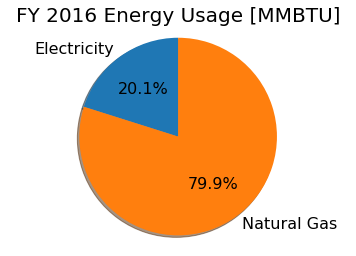

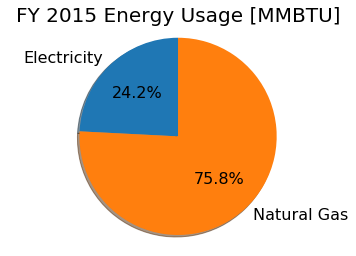

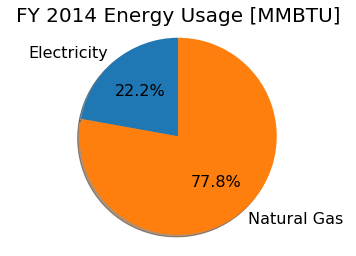

In [39]:
usage_pie_charts(usage_df2, usage_cols, 1)

# Electrical Usage Analysis

In [40]:
df.head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
0,03,Electricity,2010,7,Electricity charge,-,24.137931,35.0,0.000000,2011,1,NaN
1,03,Electricity,2010,7,Electricity charge,kWh,1304.274655,9.5,6656.551724,2011,1,22.712154
2,03,Electricity,2010,8,Electricity charge,-,39.498433,62.0,0.000000,2011,2,NaN
3,03,Electricity,2010,8,Electricity charge,kWh,4940.646254,31.0,26822.236155,2011,2,91.517470
4,03,Electricity,2010,9,Electricity charge,-,16.363636,27.0,0.000000,2011,3,NaN


In [52]:
electric_df = df.query("service_type == 'Electricity'")
electric_df = electric_df.query("units == 'kWh' or units == 'kW'")
electric_df

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
1,03,Electricity,2010,7,Electricity charge,kWh,1304.274655,9.5,6656.551724,2011,1,22.712154
3,03,Electricity,2010,8,Electricity charge,kWh,4940.646254,31.0,26822.236155,2011,2,91.517470
5,03,Electricity,2010,9,Electricity charge,kWh,6206.509032,63.0,36144.268383,2011,3,123.324244
6,03,Electricity,2010,10,Electricity charge,kWh,7637.579025,102.0,45079.667877,2011,4,153.811827
7,03,Electricity,2010,11,Electricity charge,kWh,8051.234399,90.0,47705.533154,2011,5,162.771279
8,03,Electricity,2010,12,Electricity charge,kWh,7733.783390,93.0,44821.714849,2011,6,152.931691
9,03,Electricity,2011,1,Electricity charge,kWh,6295.576913,93.0,35977.482508,2011,7,122.755170
10,03,Electricity,2011,2,Electricity charge,kWh,3954.471426,84.0,23348.498136,2011,8,79.665076
11,03,Electricity,2011,3,Electricity charge,kWh,5486.452598,93.0,30266.075075,2011,9,103.267848
12,03,Electricity,2011,4,Electricity charge,kWh,13931.666963,90.0,73957.472141,2011,10,252.342895


In [53]:
electric_df.item_desc.unique()

array(['Electricity charge', 'Actual demand', 'Utility Charge',
       'Energy charge', 'KW Charge', 'On peak demand', 'Demand Charge'], dtype=object)

In [54]:
electric_df.to_csv(r"C:\Users\dustin\Google Drive\FNSB Data Analysis\electric_testing.csv")

In [49]:
electric_pivot = pd.pivot_table(electric_df,
                                index=['fiscal_year'], 
                                columns=['item_desc'],
                                values='usage',
                                aggfunc=np.sum)

electric_pivot

item_desc,Actual demand,Demand Charge,Distribution demand,Electricity charge,Energy charge,KW Charge,On peak demand,Utility Charge,kVAR,kVARh/Excess kVARh
fiscal_year,,,,,,,,,,
2011,15785.680952,6987.041935,NaN,2.100164e+07,8.351078e+06,15459.092131,2141.700000,NaN,27.668182,NaN
2012,5147.619048,6922.686190,0.0,2.112399e+07,8.386426e+06,15197.421939,1374.470104,4.620984e+05,29.840881,NaN
2013,NaN,7668.491007,NaN,1.999839e+07,8.780579e+06,189246.085930,9797.228561,4.501616e+05,7.290938,1.0
2014,NaN,16901.068027,NaN,1.926337e+07,2.816186e+06,0.000000,4000.701335,6.056403e+06,NaN,0.0
2015,NaN,21411.798038,NaN,1.916791e+07,3.412274e+04,NaN,NaN,8.688093e+06,NaN,NaN
2016,NaN,21262.293755,NaN,1.866620e+07,3.464132e+04,NaN,NaN,8.672874e+06,NaN,NaN
2017,NaN,30634.221048,NaN,2.457148e+06,8.220000e+02,NaN,NaN,5.101849e+06,NaN,NaN


In [55]:
df_raw.head()

,Site ID,Site Name,Vendor Code,Vendor Name,Account Number,Bill Date,Due Date,Entry Date,Invoice #,Voucher #,From,Thru,Service Name,Item Description,Meter Number,Usage,Cost,Units,Account Financial Code,Site Financial Code
0,TRGR,FNSB-Transit Garage,VP287678,Sourdough Fuel (Petro Star),00013297 (closed),09/28/2010,09/28/2010,01/26/2011,NaN,NaN,2008-11-19,2010-09-28,Oil #1,FED LUS TX,NaN,NaN,3.00,NaN,NaN,NaN
1,TRGR,FNSB-Transit Garage,VP287678,Sourdough Fuel (Petro Star),00013297 (closed),09/28/2010,09/28/2010,01/26/2011,NaN,NaN,2008-11-19,2010-09-28,Oil #1,Fuel Oil #1 (Gallons),NaN,3000.0,7950.00,Gallons,NaN,NaN
2,TRGR,FNSB-Transit Garage,VP287678,Sourdough Fuel (Petro Star),00013297 (closed),09/30/2010,09/30/2010,01/26/2011,NaN,NaN,2010-09-28,2010-09-30,Oil #1,FED LUS TX,NaN,NaN,1.31,NaN,NaN,NaN
3,TRGR,FNSB-Transit Garage,VP287678,Sourdough Fuel (Petro Star),00013297 (closed),09/30/2010,09/30/2010,01/26/2011,NaN,NaN,2010-09-28,2010-09-30,Oil #1,Fuel Oil #1 (Gallons),NaN,1307.0,3463.82,Gallons,NaN,NaN
4,TRGR,FNSB-Transit Garage,VP287678,Sourdough Fuel (Petro Star),00013297 (closed),01/14/2011,01/14/2011,07/28/2014,NaN,NaN,2010-09-30,2011-01-14,Oil #1,Fuel Oil #1 (Gallons),NaN,1880.0,5545.41,Gallons,NaN,NaN


In [56]:
df_raw['Item Description'].unique()

array(['FED LUS TX', 'Fuel Oil #1 (Gallons)', 'FED OS TX',
       'Tax: Regulatory', 'Misc. fee', 'Energy charge',
       'Electricity charge', 'Steam (klbs)', 'Late charge', 'Steam (lbs)',
       'Regulatory Cost Charge', 'Steam (MMBtu) CDHW', 'Service charge',
       'Surcharge', 'Customer charge', 'Other charges', 'kVAR',
       'KW Charge', 'Fuel cost adjustment', 'Customer Charge',
       'On peak demand', 'Power Factor Charge', 'Previous balance adj.',
       'Fuel & Purchased Power', 'Utility Charge', 'Demand Charge',
       'Natural gas (CCF)', 'Gas Charge (CCF)', 'Misc. credit',
       'Fuel Adjustment', 'Discount', 'Water Usage (Gallons)',
       'Service activation', 'Facility charge', 'Sewer Usage (Gallons)',
       'Sewer Fixed Charge', 'Customer Charge - Sewer',
       'Cost of Energy Adjustmen', 'meter charge - wells',
       'Water Fixed Charge', 'Fire Protection', 'Meter charge',
       'Customer Charge - Water', 'Plant Replacement ADJ', 'Fire charge',
       'Containe

In [64]:
demand_df = df_raw.loc[(df_raw['Item Description'] == 'Demand Charge') | (df_raw['Item Description'] == 'Actual demand') \
       | (df_raw['Item Description'] == 'On peak demand')]

In [68]:
demand_dates = demand_df[['From', 'Thru']]

In [77]:
def df_split(df):
    return bench_util.split_period(df['From'], df['Thru'])

In [78]:
demand_dates.shape

(1018, 2)

In [79]:
demand_dates['results'] = demand_dates.apply(df_split, axis=1)
demand_dates

AttributeError: ("'Timestamp' object has no attribute 'values'", 'occurred at index 1345')